In [1]:
#Reference: https://towardsdatascience.com/bert-text-classification-using-pytorch-723dfb8b6b5b

In [2]:
# Libraries
import math
import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries
from sklearn.model_selection import train_test_split
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [8]:
raw_data_path = 'Data/train.csv'
destination_folder = 'Data/Processed'

train_test_ratio = 1
train_valid_ratio = 0.70

In [30]:
# Read raw data
df_raw = pd.read_csv(raw_data_path)

# Prepare columns
df_raw = df_raw.reindex(columns=['target', 'text','id'])

# Split according to label
df_fake = df_raw[df_raw['target'] == 0]
df_real = df_raw[df_raw['target'] == 1]

# Train-test split
#df_real_full_train, df_real_test = train_test_split(df_real, train_size = train_test_ratio, random_state = 1)
#df_fake_full_train, df_fake_test = train_test_split(df_fake, train_size = train_test_ratio, random_state = 1)

# Train-valid split
df_real_train, df_real_valid = train_test_split(df_real, train_size = train_valid_ratio, random_state = 1)
df_fake_train, df_fake_valid = train_test_split(df_fake, train_size = train_valid_ratio, random_state = 1)

# Concatenate splits of different labels
df_train = pd.concat([df_real_train, df_fake_train], ignore_index=True, sort=False)
df_valid = pd.concat([df_real_valid, df_fake_valid], ignore_index=True, sort=False)
#df_test = pd.concat([df_real_test, df_fake_test], ignore_index=True, sort=False)

# Write preprocessed data
df_train.to_csv(destination_folder + '/train.csv', index=False)
df_valid.to_csv(destination_folder + '/valid.csv', index=False)
#df_test.to_csv(destination_folder + '/test.csv', index=False)

In [31]:
test_raw = pd.read_csv('Data/test.csv')
test_raw = test_raw.reindex(columns=['text','id'])
test_raw.to_csv(destination_folder + '/test.csv', index=False)

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [65]:
source_folder = 'Data/Processed'
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
id_field = Field(sequential=False, use_vocab=False, batch_first=True,dtype=torch.int)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('target', label_field),('text', text_field),('id', id_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv',
                                           test='test.csv', format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)

In [66]:
test_fields =[('text', text_field),('id', id_field)]
test_data = TabularDataset(path='Data/Processed/test.csv', fields=test_fields, format='CSV', skip_header=True)
test_iter = Iterator(test_data, batch_size=16, device=device, train=False, shuffle=False, sort=False)

In [5]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, target):
        loss, text_fea = self.encoder(text, labels=target)[:2]

        return loss, text_fea

In [6]:
def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [39]:
def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (target, text, ids), _ in train_loader:
            target = target.type(torch.LongTensor)           
            target = target.to(device)
            text = text.type(torch.LongTensor)  
            text = text.to(device)
            output = model(text, target)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (target, text, ids), _ in valid_loader:
                        target = target.type(torch.LongTensor)           
                        target = target.to(device)
                        text = text.type(torch.LongTensor)  
                        text = text.to(device)
                        output = model(text, target)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

train(model=model, optimizer=optimizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch [1/5], Step [166/1665], Train Loss: 0.6556, Valid Loss: 0.6752
Model saved to ==> Data/Processed/model.pt
Model saved to ==> Data/Processed/metrics.pt
Epoch [1/5], Step [332/1665], Train Loss: 0.5398, Valid Loss: 0.4284
Model saved to ==> Data/Processed/model.pt
Model saved to ==> Data/Processed/metrics.pt
Epoch [2/5], Step [498/1665], Train Loss: 0.4461, Valid Loss: 0.4294
Epoch [2/5], Step [664/1665], Train Loss: 0.3319, Valid Loss: 0.4457
Epoch [3/5], Step [830/1665], Train Loss: 0.3279, Valid Loss: 0.4170
Model saved to ==> Data/Processed/model.pt
Model saved to ==> Data/Processed/metrics.pt
Epoch [3/5], Step [996/1665], Train Loss: 0.2410, Valid Loss: 0.5312
Epoch [4/5], Step [1162/1665], Train Loss: 0.2250, Valid Loss: 0.4884
Epoch [4/5], Step [1328/1665], Train Loss: 0.1772, Valid Loss: 0.5899
Epoch [5/5], Step [1494/1665], Train Loss: 0.1684, Valid Loss: 0.5311
Epoch [5/5], Step [1660/1665], Train Loss: 0.1400, Valid Loss: 0.6567
Model saved to ==> Data/Processed/metrics.

In [40]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

train(model=model, optimizer=optimizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch [1/5], Step [166/1665], Train Loss: 0.6607, Valid Loss: 0.6820
Model saved to ==> Data/Processed/model.pt
Model saved to ==> Data/Processed/metrics.pt
Epoch [1/5], Step [332/1665], Train Loss: 0.6530, Valid Loss: 0.4772
Model saved to ==> Data/Processed/model.pt
Model saved to ==> Data/Processed/metrics.pt
Epoch [2/5], Step [498/1665], Train Loss: 0.4813, Valid Loss: 0.4396
Model saved to ==> Data/Processed/model.pt
Model saved to ==> Data/Processed/metrics.pt
Epoch [2/5], Step [664/1665], Train Loss: 0.3928, Valid Loss: 0.4181
Model saved to ==> Data/Processed/model.pt
Model saved to ==> Data/Processed/metrics.pt
Epoch [3/5], Step [830/1665], Train Loss: 0.3514, Valid Loss: 0.4217
Epoch [3/5], Step [996/1665], Train Loss: 0.2836, Valid Loss: 0.4940
Epoch [4/5], Step [1162/1665], Train Loss: 0.2674, Valid Loss: 0.4345
Epoch [4/5], Step [1328/1665], Train Loss: 0.2065, Valid Loss: 0.5607
Epoch [5/5], Step [1494/1665], Train Loss: 0.2116, Valid Loss: 0.5233
Epoch [5/5], Step [1660/

Model loaded from <== Data/Processed/metrics.pt


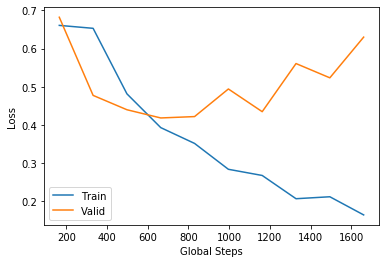

In [41]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [121]:
# Evaluation Function

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (target, text, ids), _ in test_loader:

                target = target.type(torch.LongTensor)           
                target = target.to(device)
                text = text.type(torch.LongTensor)  
                text = text.to(device)
                output = model(text, target)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(target.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['0', '1'])
    ax.yaxis.set_ticklabels(['0', '1'])

In [9]:
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

device = torch.device('cpu')
best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

#evaluate(best_model, test_iter)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== Data/Processed/model.pt


0.4181033492713541

In [30]:
count = 0
y_pred = []
y_true = []
for (text, ids), _ in test_iter:
    target = torch.zeros([16],dtype=torch.int64)
    target = target.to(device)
    text = text.type(torch.LongTensor)  
    text = text.to(device)
    output = best_model(text, target)
    _, output = output
    y_pred.extend(torch.argmax(output, 1).tolist())
    print(y_pred)
    y_true.extend(target.tolist())
    print(y_true)
    print(ids)
    break

[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
tensor([ 0,  2,  3,  9, 11, 12, 21, 22, 27, 29, 30, 35, 42, 43, 45, 46],
       dtype=torch.int32)


In [33]:
type(ids)

torch.Tensor

In [34]:
ids.numpy()

array([ 0,  2,  3,  9, 11, 12, 21, 22, 27, 29, 30, 35, 42, 43, 45, 46])

In [23]:
x = torch.zeros([16],dtype=torch.long)

torch.int64

In [81]:
_,output = output

In [83]:
t = []
p = []
p.extend(torch.argmax(output, 1).tolist())
t.extend(target.tolist())

In [91]:
import numpy as np
print(np.random.randn(10,5).shape)
print(np.random.randn(5,10))

(10, 5)
[[ 9.71337980e-01 -9.16615392e-01  1.52823572e+00 -6.94404476e-02
  -1.14302229e+00 -6.83537136e-01 -1.66645562e+00  2.23156725e+00
   1.32472577e+00 -2.48637224e-01]
 [ 1.53463781e+00  1.42547547e-01 -1.79566195e-01 -8.83201361e-01
  -9.72950729e-01 -2.35849733e-01  6.70962379e-01 -9.00436701e-01
   1.37127024e-01 -9.86119223e-01]
 [-1.45755459e+00 -3.72893580e-01  4.61743981e-01 -1.86624481e-01
   8.39905487e-04  1.21898380e+00 -2.55082061e+00 -2.92543242e-01
  -5.70176893e-01 -3.52101772e-02]
 [ 6.20264736e-01  1.38660215e-01  7.17874824e-01  2.44303567e-01
   7.92765219e-01  4.54828306e-01 -1.43805085e-01  5.92621934e-01
  -7.18916422e-01  2.31681704e-01]
 [ 1.27382304e+00 -3.17596750e-01 -1.67531656e-01  1.24833757e+00
  -9.35660997e-01 -9.21420574e-01  2.39396903e-01  3.75301891e-02
  -5.77347294e-02 -4.83111850e-01]]


In [85]:
p

[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]

In [68]:
def evaluateToCSV(model, test_loader):
    y_pred = []
    id_list = []

    model.eval()
    count = 0
    with torch.no_grad():
        for (text,idn), _ in test_loader:
                target = torch.zeros([16],dtype=torch.int64)      
                target = target.to(device)
                text = text.type(torch.LongTensor)  
                text = text.to(device)
                id_list.extend(idn.numpy())
                output = model(text, target)
                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                print("Iteration: %d" % count)
                count += 1
    
    print("FINISHED, predicted %d tweets" % (len(y_pred)))
    submission_df = pd.DataFrame()
    submission_df['prediction'] = y_pred
    submission_df['id'] = id_list
    return submission_df

In [69]:
submission_df = evaluateToCSV(best_model, test_iter)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
It

In [79]:
submission_df = submission_df[submission_df['id'] != -1]
submission_df = submission_df[['id','prediction']]
submission_df.head()
submission_df.columns = ['id', 'target']

In [81]:
submission_df.to_csv('Data/Processed/PyTorchSubmission.csv',index=False)

'0'